# Nichesphere differential co-localization and spatially aware process based communication tutorial

Nichesphere is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This tutorial focuses on defining groups of cells that converge or split in disease (Ischemia) based on differential co-localization. 

Nichesphere also offers the possibility to look at localized process based differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from LIANA and CrossTalkeR(Nagai et. al., 2021). This improves the interpretability of cell communication analysis as we will find changes in biological processes related to the changes in physical cell interactions. For this tutorial, we will use our self compiled database which classifies ligands according to extracellular matrix (ECM) or immune cell recruitment related processes: https://github.com/CostaLab/Nichesphere/tree/main/nichesphere/db


## 1. Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import sklearn
import igraph as ig
import mudata as md
from community_layout.layout_class import CommunityLayout
warnings.filterwarnings("ignore")

import nichesphere

COMMUNITY LAYOUT: Datashader not found, edge bundling not available


## 2. Data at first glance

In this example we will use data from the Myocardial Infarction atlas from Kuppe, C. et. al., 2022 . This is a subset with **23 snRNA and Visium 10x paired samples** (samples with less than 1500 cells in the snRNA-seq data were filtered out), and **33 different cell subtypes**

In [2]:
mudata=md.read('../../../../data_vt3/second/nichesphere/2306_HMI_allmodalities.h5mu')
mudata

MuData object with n_obs × n_vars = 76798 × 39120
  2 modalities
    sc:	48547 x 27416
      obs:	'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'doublet_score', 'doublet', 'dissociation_s1', 'opt_clust', 'patient', 'batch', 'opt_clust_integrated', 'cell_type', 'ident', 'nFeaturess_RNA', 'cell_subtype2', 'patient_region_id', 'sampleType'
      var:	'n_counts'
      obsm:	'X_harmony', 'X_pca', 'X_umap_harmony'
    visium:	28251 x 11704
      obs:	'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'patient_region_id', 'orig_ident', 'batch'
      var:	'features'
      obsm:	'X_pca', 'X_spatial', 'X_umap'

In [3]:
mudata['sc'].obsm['umap']=mudata['sc'].obsm['X_umap_harmony']

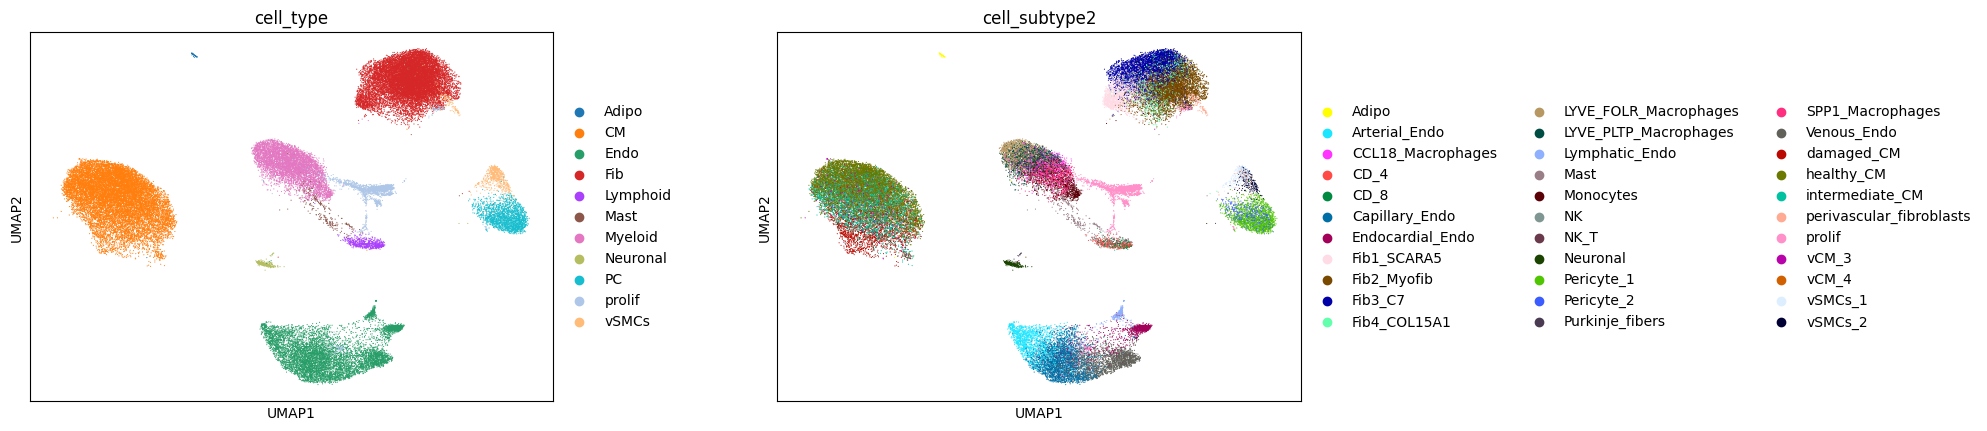

In [4]:
sc.pl.umap(mudata['sc'], 
           color=['cell_type', 'cell_subtype2'], wspace=0.3)

In this case, we will get cell type co-localization probabilities from **deconvoluted Visium** data (Cell type probabilities per spot): 

In a previous step, we used MOSCOT(Klein et. al., 2025) to deconvolute cell subtypes in visium slices from the same 23 samples , getting matrices of probabilities of each cell being in each spot. Then we got cell type probabilities per spot summing the probabilities of cells of the same kind in each spot; thus getting cell type probability matrices for all samples.

In [5]:
CTprops=pd.read_csv('../../../../data_vt3/second/nichesphere/CTprops_myoIsc.csv', index_col=0)
CTprops.head()

Fib1_SCARA5  damaged_CM  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0    0.000000   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0    0.000000   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0    0.000000   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0    0.328716   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0    0.000000   

                                                    Capillary_Endo  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...             0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...             0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...             0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...             0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...             0.0   

                                                    LYVE_FOLR_Macrophages  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                    0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                    0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                    0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                    0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                    0.0   

                                                     Fib3_C7  healthy_CM  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000    1.000000   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000    0.000000   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.358745    0.282511   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000    0.335562   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.994955    0.005045   

                                                    Fib2_Myofib  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...          0.0   

                                                    Endocardial_Endo  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...               0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...               0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...               0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...               0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...               0.0   

                                                    Arterial_Endo  Neuronal  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...   1.249070e-32       0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...   0.000000e+00       0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...   0.000000e+00       0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...   0.000000e+00       0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...   0.000000e+00       0.0   

                                                    ...  CCL18_Macrophages  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  ...                0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  ...                0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  ...                0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  ...                0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  ...                0.0   

                                                    perivascular_fibroblasts  \
AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                       0.0   
AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                       0.0   
AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                       0.0   
AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...                       0.0   
AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...      

From these deconvolution results, we can look at **cell type proportions per sample**. For this we will need the spot ID and sample correspondence:

In [6]:
spotSamples=mudata['visium'].obs.patient_region_id
spotSamples.reset_index().head()

index patient_region_id
0  AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...       control_P17
1  AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...       control_P17
2  AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...       control_P17
3  AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...       control_P17
4  AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...       control_P17

A way to check the deconvolution proportions is using a clustermap

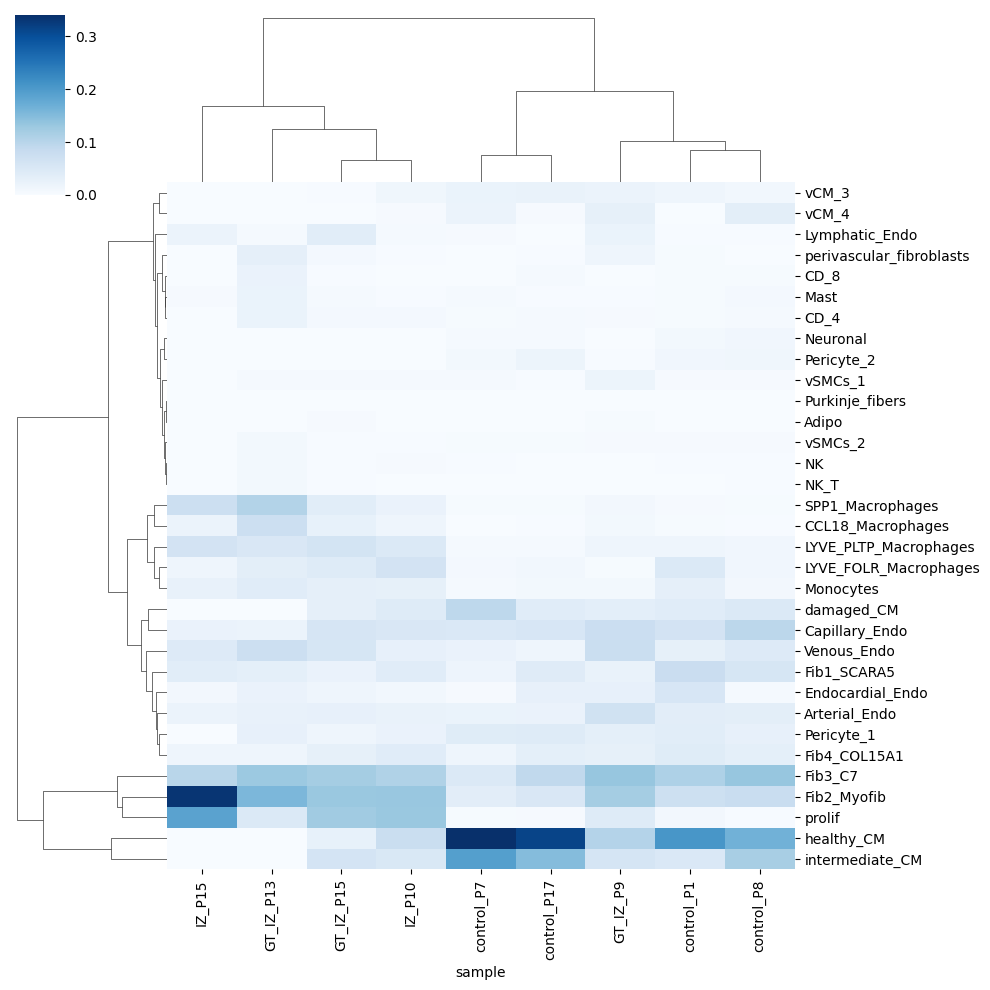

In [7]:
CTprops_sample=CTprops.copy()
CTprops_sample['sample']=mudata['visium'].obs.patient_region_id
sns.clustermap(CTprops_sample.groupby('sample').sum().T/CTprops_sample.groupby('sample').sum().sum(axis=1) , 
               cmap='Blues', method='ward')

Alternativelly, we can check the deconvolution proportions using barplots

In [8]:
t1=pd.DataFrame(CTprops[spotSamples=='control_P7'].sum(), columns=['control_P7'])
t2=pd.DataFrame(CTprops[spotSamples=='IZ_P15'].sum(), columns=['IZ_P15'])

Text(0.5, 1.0, 'IZ_P15')

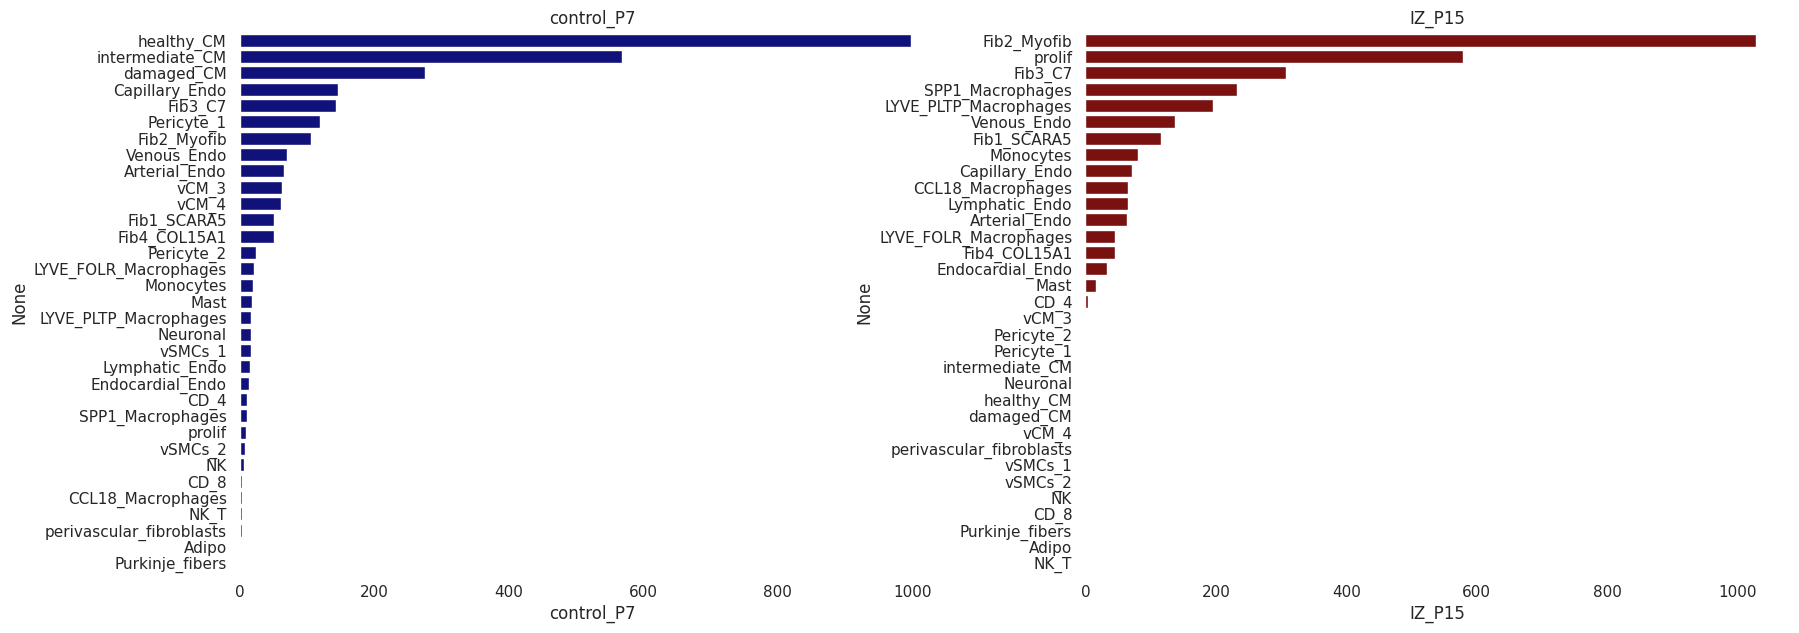

In [9]:
sns.set(font_scale=1)
sns.set_style(rc = {'axes.facecolor': 'white'})

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(ax=axes[0], y=t1.sort_values('control_P7', ascending=False).index, x='control_P7', 
            data=t1.sort_values('control_P7', ascending=False), color='darkblue')
axes[0].set_title('control_P7')

sns.barplot(ax=axes[1], y=t2.sort_values('IZ_P15', ascending=False).index, x='IZ_P15',
            data=t2.sort_values('IZ_P15', ascending=False), color='darkred')
axes[1].set_title('IZ_P15')

We can visualize **cell type deconvolution results in slices** (spots are colored by the the cell type with highest proportion). For this we will need the spatial coordinates of the spots in the Visium slices need to be in the slot **uns['spatial']** of the Visium anndata object:

In [10]:
mudata['visium'].uns['spatial']=mudata['visium'].obsm['X_spatial']

saving figure to file figures/showtest.pdf


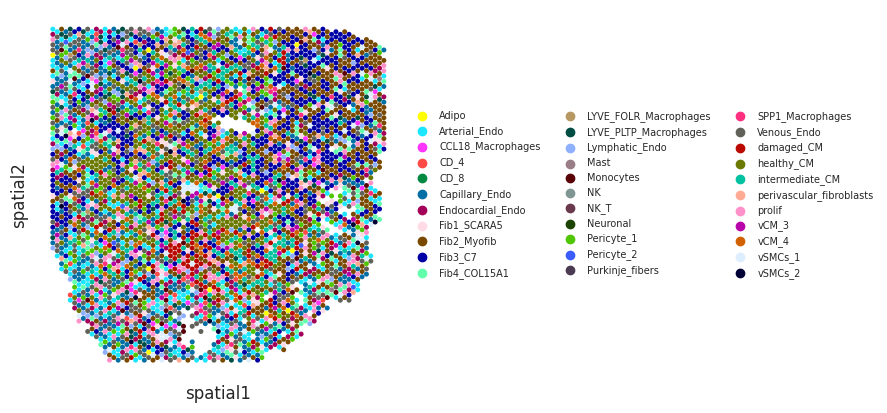

In [11]:
idPat = 'GT_IZ_P9'
nichesphere.coloc.spatialCTPlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==idPat].copy(), 
                                CTprobs=CTprops.loc[spotSamples.index[spotSamples==idPat]], 
                                cell_types=mudata['sc'].obs.cell_subtype2, spot_size=0.015, 
                                legend_fontsize=7)

## 3. Co-localization

We computed then co-localization probabilities from the cell type probability matrices,getting a matrix of cell type pairs x samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [12]:
colocPerSample=pd.read_csv('../../../../data_vt3/second/nichesphere/colocPerSample_myoIsc.csv', index_col=0)
colocPerSample.head()

Fib1_SCARA5-Fib1_SCARA5  Fib1_SCARA5-damaged_CM  \
control_P17                 0.017603                0.000308   
IZ_P15                      0.030351                0.000000   
GT_IZ_P13                   0.018084                0.000000   
GT_IZ_P15                   0.020017                0.000040   
GT_IZ_P9                    0.019715                0.000200   

             Fib1_SCARA5-Capillary_Endo  Fib1_SCARA5-LYVE_FOLR_Macrophages  \
control_P17                    0.000992                       2.507278e-04   
IZ_P15                         0.000027                       1.859005e-04   
GT_IZ_P13                      0.000154                       3.540328e-04   
GT_IZ_P15                      0.000107                       1.413835e-05   
GT_IZ_P9                       0.000250                       3.609267e-33   

             Fib1_SCARA5-Fib3_C7  Fib1_SCARA5-healthy_CM  \
control_P17             0.007062            2.586003e-03   
IZ_P15                  0.001200            0.000000e+00   
GT_IZ_P13               0.003069            0.000000e+00   
GT_IZ_P15               0.000772            4.690843e-16   
GT_IZ_P9                0.000643            3.859817e-04   

             Fib1_SCARA5-Fib2_Myofib  Fib1_SCARA5-Endocardial_Endo  \
control_P17                 0.004724                  9.427749e-04   
IZ_P15                      0.003112                  7.228002e-05   
GT_IZ_P13                   0.002831                  4.390572e-04   
GT_IZ_P15                   0.000702                  6.130994e-09   
GT_IZ_P9                    0.000741                  2.134773e-04   

             Fib1_SCARA5-Arterial_Endo  Fib1_SCARA5-Neuronal  ...  \
control_P17                   0.000412              0.000351  ...   
IZ_P15                        0.000062              0.000000  ...   
GT_IZ_P13                     0.000276              0.000000  ...   
GT_IZ_P15                     0.000152              0.000000  ...   
GT_IZ_P9                      0.000366              0.000000  ...   

             NK_T-CCL18_Macrophages  NK_T-perivascular_fibroblasts  NK_T-CD_4  \
control_P17            2.290066e-15                   0.000000e+00   0.000039   
IZ_P15                 0.000000e+00                   0.000000e+00   0.000000   
GT_IZ_P13              8.345726e-05                   1.007656e-05   0.000260   
GT_IZ_P15              0.000000e+00                   7.448928e-30   0.000000   
GT_IZ_P9               0.000000e+00                   0.000000e+00   0.000000   

             NK_T-vSMCs_2  NK_T-Lymphatic_Endo       NK_T-NK     NK_T-CD_8  \
control_P17           0.0         0.000000e+00  4.538656e-08  4.556003e-08   
IZ_P15                0.0         0.000000e+00  0.000000e+00  0.000000e+00   
GT_IZ_P13             0.0         0.000000e+00  0.000000e+00  3.963644e-04   
GT_IZ_P15             0.0         3.143464e-46  0.000000e+00  3.756373e-28   
GT_IZ_P9              0.0         0.000000e+00  0.000000e+00  0.000000e+00   

             NK_T-Purkinje_fibers  NK_T-Adipo  NK_T-NK_T  
control_P17                   0.0         0.0   0.000268  
IZ_P15                        0.0         0.0   0.000000  
GT_IZ_P13                     0.0         0.0   0.004869  
GT_IZ_P15                     0.0         0.0   0.001477  
GT_IZ_P9                      0.0         0.0   0.000000  

[5 rows x 1089 columns]

The sum of the probabilities of every cell type pair in a sample must be = 1

In [13]:
colocPerSample.sum(axis=1)

control_P17    1.0
IZ_P15         1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
GT_IZ_P9       1.0
IZ_P10         1.0
control_P7     1.0
control_P1     1.0
control_P8     1.0
dtype: float64

**Same cell type interactions** will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [14]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types

**Conditions**

We will need the following metadata to subset the samples in **control (myogenic)** and **disease (ischemic)**:

In [15]:
sampleTypesDF=pd.read_csv('../../../../data_vt3/second/nichesphere/MI_sampleTypesDF_myoIsc.csv', index_col=0)
sampleTypesDF.head()

sample sampleType
0   control_P17   myogenic
2        IZ_P15   ischemic
8     GT_IZ_P13   ischemic
9     GT_IZ_P15   ischemic
12     GT_IZ_P9   ischemic

## 4. Differential co-localization analysis

We will test differential co-localization between **myogenic** and **ischemic** samples using Wilcoxon rank sums tests:

**Null Hypothesis (H0):**
The median of the population of differences between co-localization probabilities of cell types a and b in myogenic and ischemic samples is zero.

**Alternative Hypothesis (H1):**
The median of the population of differences between co-localization probabilities of cell types a and b in myogenic and ischemic samples is not equal to zero.

In [16]:
myo_iscDF=nichesphere.coloc.diffColoc_test(coloc_pair_sample=colocPerSample, 
                                           sampleTypes=sampleTypesDF, 
                                           exp_condition='ischemic', 
                                           ctrl_condition='myogenic')
myo_iscDF.head()

pairs  \
pairs                                                                  
Fib1_SCARA5-Fib1_SCARA5                      Fib1_SCARA5-Fib1_SCARA5   
Fib1_SCARA5-damaged_CM                        Fib1_SCARA5-damaged_CM   
Fib1_SCARA5-Capillary_Endo                Fib1_SCARA5-Capillary_Endo   
Fib1_SCARA5-LYVE_FOLR_Macrophages  Fib1_SCARA5-LYVE_FOLR_Macrophages   
Fib1_SCARA5-Fib3_C7                              Fib1_SCARA5-Fib3_C7   

                                  statistic   p-value  
pairs                                                  
Fib1_SCARA5-Fib1_SCARA5            0.489898  0.624206  
Fib1_SCARA5-damaged_CM             -2.44949  0.014306  
Fib1_SCARA5-Capillary_Endo        -2.204541  0.027486  
Fib1_SCARA5-LYVE_FOLR_Macrophages -0.489898  0.624206  
Fib1_SCARA5-Fib3_C7                -2.44949  0.014306

Then we will reshape the data to visualize the Wilcoxon test scores in a heatmap and filter non significant co-localization differences using the parameter **p** (in this case, scores with p-values > 0.1 are filtered out)

In [17]:
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, 
                                             oneCTinteractions=oneCTints, 
                                             p=0.1,                             #threshold p-value to filter
                                             cell_types=cell_types)
myo_isc_HM.head()

Fib1_SCARA5  damaged_CM  Capillary_Endo  \
Fib1_SCARA5               0.000000   -2.449490       -2.204541   
damaged_CM               -2.449490    0.000000       -2.204541   
Capillary_Endo           -2.204541   -2.204541        0.000000   
LYVE_FOLR_Macrophages     0.000000   -1.959592        0.000000   
Fib3_C7                  -2.449490   -2.449490       -2.204541   

                       LYVE_FOLR_Macrophages   Fib3_C7  healthy_CM  \
Fib1_SCARA5                         0.000000 -2.449490   -2.449490   
damaged_CM                         -1.959592 -2.449490   -2.449490   
Capillary_Endo                      0.000000 -2.204541   -2.449490   
LYVE_FOLR_Macrophages               0.000000  0.000000   -1.959592   
Fib3_C7                             0.000000  0.000000   -2.449490   

                       Fib2_Myofib  Endocardial_Endo  Arterial_Endo  Neuronal  \
Fib1_SCARA5              -1.959592          0.000000       0.000000 -2.449490   
damaged_CM               -2.204541         -2.449490      -2.204541 -2.449490   
Capillary_Endo            0.000000         -2.204541      -2.449490 -2.449490   
LYVE_FOLR_Macrophages     0.000000          0.000000       0.000000 -1.837117   
Fib3_C7                   0.000000          0.000000      -1.714643 -2.449490   

                       ...  CCL18_Macrophages  perivascular_fibroblasts  \
Fib1_SCARA5            ...           0.000000                       0.0   
damaged_CM             ...           0.000000                       0.0   
Capillary_Endo         ...           0.000000                       0.0   
LYVE_FOLR_Macrophages  ...           0.000000                       0.0   
Fib3_C7                ...           1.714643                       0.0   

                          CD_4   vSMCs_2  Lymphatic_Endo   NK      CD_8  \
Fib1_SCARA5            0.00000  0.000000             0.0  0.0  0.000000   
damaged_CM            -2.44949 -1.959592             0.0  0.0 -2.204541   
Capillary_Endo        -2.44949  0.000000             0.0  0.0 -2.449490   
LYVE_FOLR_Macrophages  0.00000  0.000000             0.0  0.0  0.000000   
Fib3_C7                0.00000  0.000000             0.0  0.0  0.000000   

                       Purkinje_fibers  Adipo      NK_T  
Fib1_SCARA5                          0      0  0.000000  
damaged_CM                           0      0 -1.837117  
Capillary_Endo                       0      0  0.000000  
LYVE_FOLR_Macrophages                0      0  0.000000  
Fib3_C7                              0      0  0.000000  

[5 rows x 33 columns]

As the cells classified as proliferating cells (prolif) are many different cell types and thus hard to interpret, we'll remove them for further analysis.

In [18]:
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

We will also remove cells with no significant co-localization differences

In [19]:
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.sum()!=0,myo_isc_HM.sum()!=0]

Now we can plot the differential co-localization scores heatmap

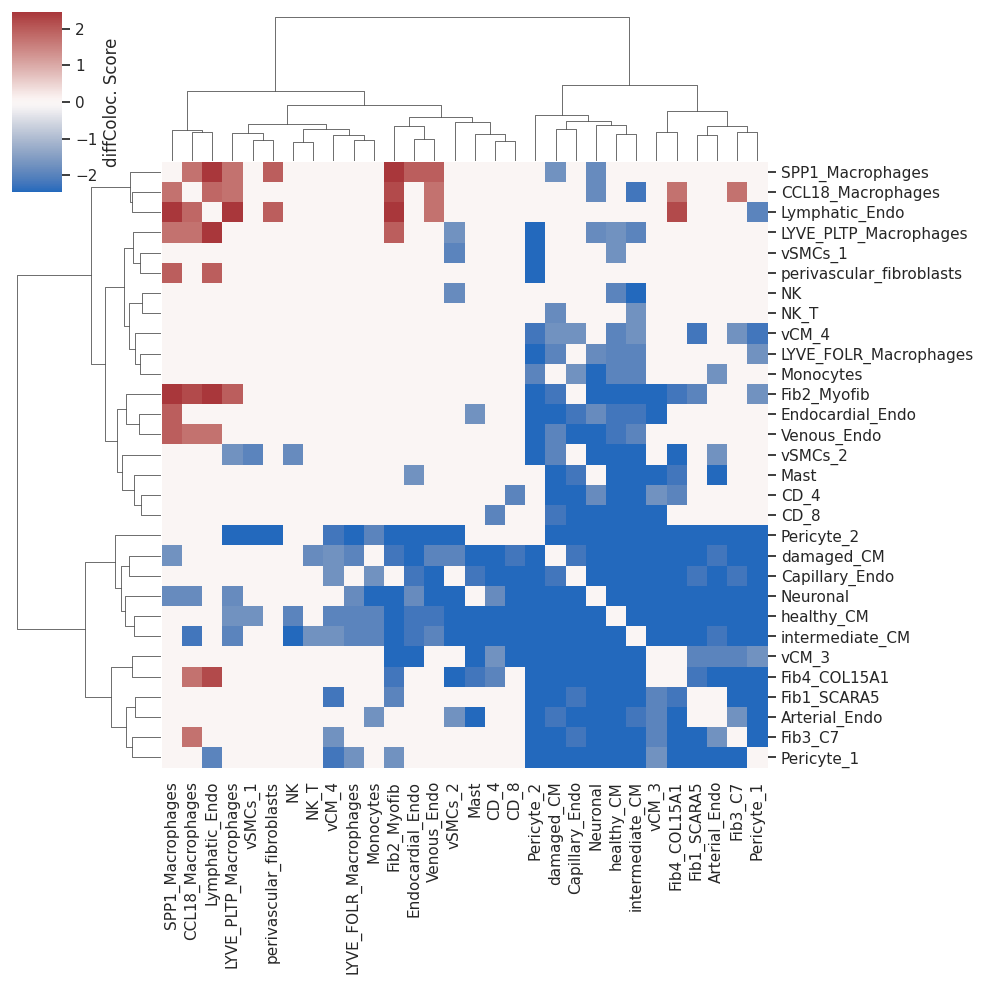

In [20]:
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

**Differential co-localization network**

To build the differential co-localization network, we will get an **adjacency matrix** (adj) based on the **euclidean distances** among the distributions of significant differential co-localization scores for the different cell types

In [21]:
## Distance matrix
HMdist=pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(myo_isc_HM)), 
                    columns=myo_isc_HM.columns, index=myo_isc_HM.index)
## Adjacency matrix
HMsimm=1-HMdist/HMdist.max().max()
##Cell pairs with no significant differential co-localization get 0 adjacency
HMsimm[myo_isc_HM==0]=0

A **cell group dictionary** should be used here to visualize different cell groups in different colors. As we don't have cell groups yet, we'll have a dictionary of all cells in one group and a list of one color

In [22]:
niches_dict={'1_': list(myo_isc_HM.index)}
clist=['#4daf4a']

Now we can plot the differential co-localization network using the **colocNW** function from Nichesphere. This function has many parameters that can be tuned: 

**nodeSize** for example, defines how the size of the nodes will be calculated. Options are 'betweeness', 'pagerank' (both network statistics) and None (all nodes have the same size).
**alpha** indicates the transparency of the edges and in goes from 0 (completely transparent) to 1 (opaque)
**fsize** is the size of the figure (x,y)

This function returns the network with the edge weights corresponding to the diff. coloc. scores (positive and negative)

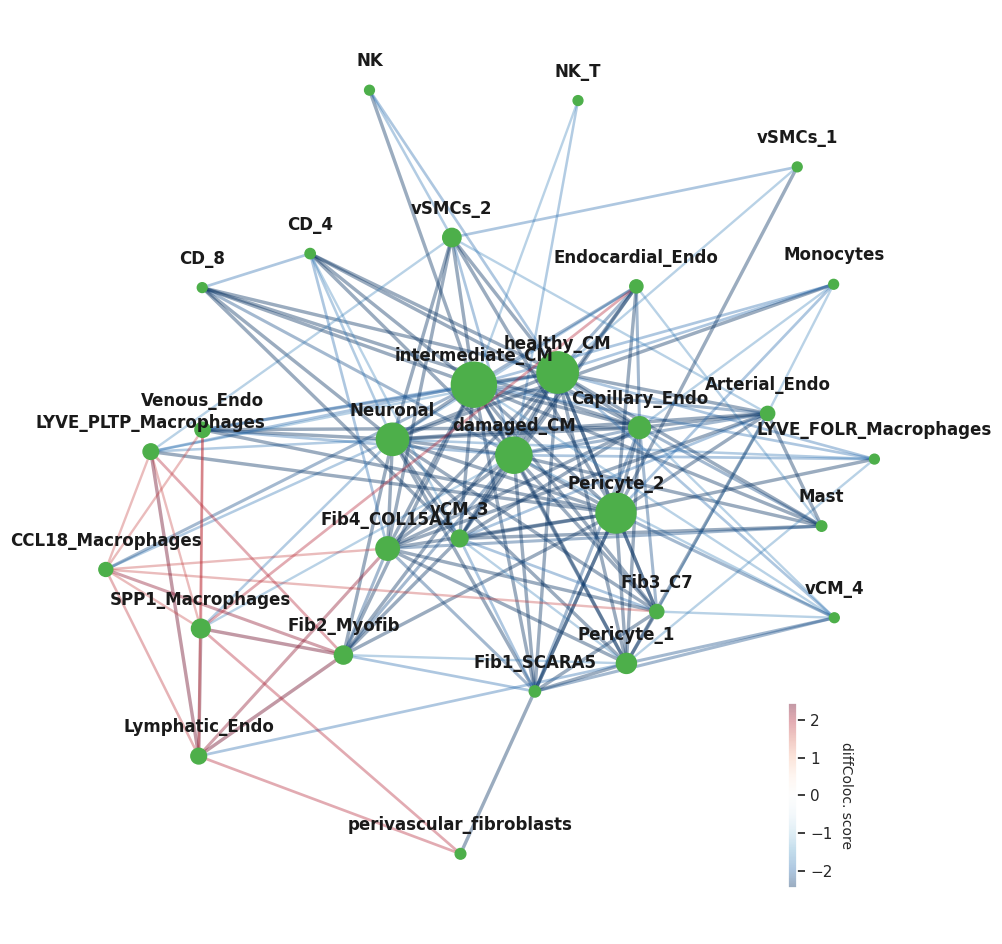

In [23]:
plt.rcParams['axes.facecolor'] = "None"
nichesphere.coloc.colocNW(x_diff=myo_isc_HM,            #differential co-localization matrix
                          adj=HMsimm,                   #adjacency matrix
                          cell_group=niches_dict, 
                          clist=clist, 
                          nodeSize='betweeness',        
                          lab_spacing=9,                #space between node and label
                          alpha=0.4,                    #edges transparency
                          fsize=(12,12))                #figure size

Now we'll do community detection using Louvain. First we will get the network from the adjacency matrix as we won't use the signed weights for this

In [24]:
gCol_unsigned=nx.from_pandas_adjacency(HMsimm, create_using=nx.Graph)

We will use the community-layout library function **CommunityLayout** to show the communities in a layout suited for this. This function is compatible with networkx (Hagberg et. al., 2008) community detection functions, which will be used internally as indicated by the parameters **community_algorithm** and **community_kwargs**

In [25]:
## Calculate community layout
cl=CommunityLayout(gCol_unsigned,
        community_compression = 0.4,
        layout_algorithm = nx.spring_layout,
        layout_kwargs = {"k":75, "iterations":1000},
        community_algorithm = nx.algorithms.community.louvain_communities,
        community_kwargs = {"resolution":1.1,  'seed':12, 'weight':'weight'})

Building meta-graph
Metagraph is a Graph with 4 nodes and 6 edges


100%|██████████| 4/4 [00:00<00:00, 141.32it/s]


In [26]:
#cl.communities()

We can extract the communities as follows

In [27]:
d = {index: list(value) for index, value in enumerate(cl.communities())}
print(pd.DataFrame.from_dict(d, orient='index').T.to_string(index=False))

           0                     1             2                        3
  Pericyte_2                  Mast       vSMCs_1        CCL18_Macrophages
     Fib3_C7              Neuronal       vSMCs_2              Fib2_Myofib
  Pericyte_1                 vCM_3     Monocytes    LYVE_PLTP_Macrophages
       vCM_4       intermediate_CM            NK perivascular_fibroblasts
 Fib1_SCARA5 LYVE_FOLR_Macrophages    healthy_CM         SPP1_Macrophages
Fib4_COL15A1            damaged_CM Arterial_Endo              Venous_Endo
        None                  CD_8          None           Lymphatic_Endo
        None                  NK_T          None                     None
        None      Endocardial_Endo          None                     None
        None        Capillary_Endo          None                     None
        None                  CD_4          None                     None


And then name the niches

In [28]:
niche_names=['1_Stromal', '2_Stressed_CM', '3_Healthy_CM', '4_Fibrotic']
niches_dict=dict(zip(niche_names,list(d.values()))) 
print(pd.DataFrame.from_dict(niches_dict, orient='index').T.to_string(index=False))

   1_Stromal         2_Stressed_CM  3_Healthy_CM               4_Fibrotic
  Pericyte_2                  Mast       vSMCs_1        CCL18_Macrophages
     Fib3_C7              Neuronal       vSMCs_2              Fib2_Myofib
  Pericyte_1                 vCM_3     Monocytes    LYVE_PLTP_Macrophages
       vCM_4       intermediate_CM            NK perivascular_fibroblasts
 Fib1_SCARA5 LYVE_FOLR_Macrophages    healthy_CM         SPP1_Macrophages
Fib4_COL15A1            damaged_CM Arterial_Endo              Venous_Endo
        None                  CD_8          None           Lymphatic_Endo
        None                  NK_T          None                     None
        None      Endocardial_Endo          None                     None
        None        Capillary_Endo          None                     None
        None                  CD_4          None                     None


And assign them colors to color the network nodes according to their cluster

In [29]:
clist=['#4daf4a', '#0072B5', '#BC3C29', '#ffff33']
niche_cols=pd.Series(clist, index=list(niches_dict.keys()))
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, 
                                            niche_colors=niche_cols, 
                                            niche_dict=niches_dict)
niches_df.head()

cell          niche    color
cell                                                                
Fib1_SCARA5                      Fib1_SCARA5      1_Stromal  #4daf4a
damaged_CM                        damaged_CM  2_Stressed_CM  #0072B5
Capillary_Endo                Capillary_Endo  2_Stressed_CM  #0072B5
LYVE_FOLR_Macrophages  LYVE_FOLR_Macrophages  2_Stressed_CM  #0072B5
Fib3_C7                              Fib3_C7      1_Stromal  #4daf4a

Then we can get the node positions to input them to the nichesphere **colocNW** function through the **pos** parameter

In [30]:
pos=cl.full_positions

And plot the niches on the community layout

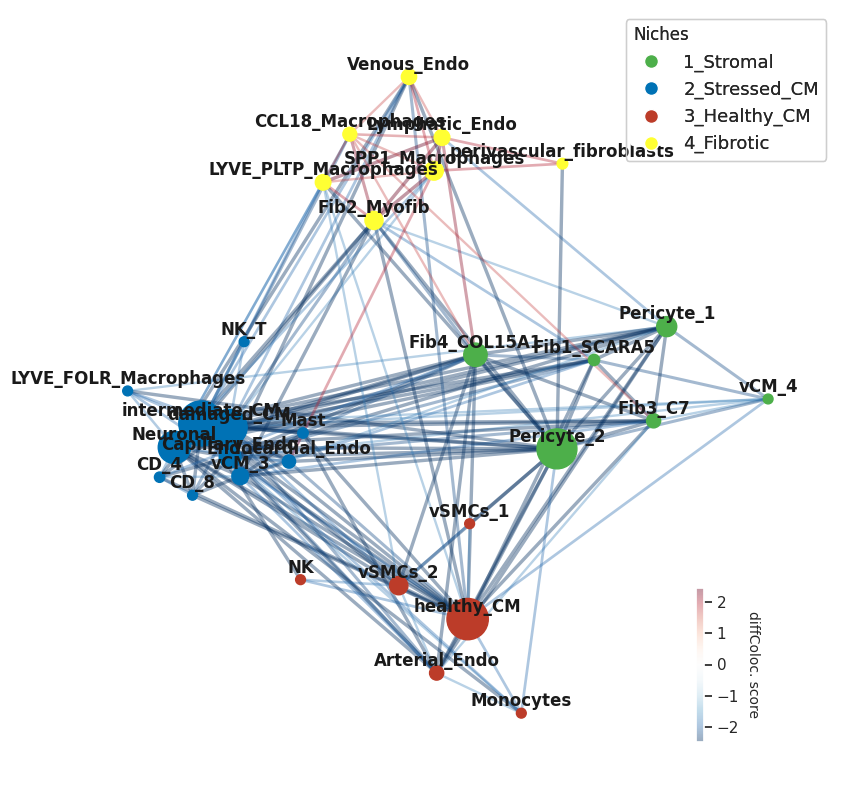

In [31]:
plt.rcParams['axes.facecolor'] = "None"

gCol=nichesphere.coloc.colocNW(x_diff=myo_isc_HM, 
                               adj=HMsimm,
                               cell_group=niches_dict, 
                               clist=clist, 
                               nodeSize='betweeness', 
                               layout=None,                         #layout needs to be set to None if we provide node positions
                               lab_spacing=0.05, 
                               thr=1, 
                               alpha=0.4, 
                               fsize=(10,10), 
                               pos=pos,                             #node positions (from the CommunityLayout function)
                               edge_scale=1,                        #edge width
                               legend_ax=[0.7, 0.05, 0.15, 0.2])    #legend position
#Legend
legend_elements1=[plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[i], lw=4, 
                             label=list(niches_dict.keys())[i], ms=10) for i in range(len(list(niches_dict.keys())))]
plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper right', fontsize=13, title='Niches', 
                                alignment='left'))
#plt.savefig('./diffColocNW_CD.pdf')

We can also calculate some network statistics with the networkx package functions (this will be done on the signed network):

In [32]:
t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

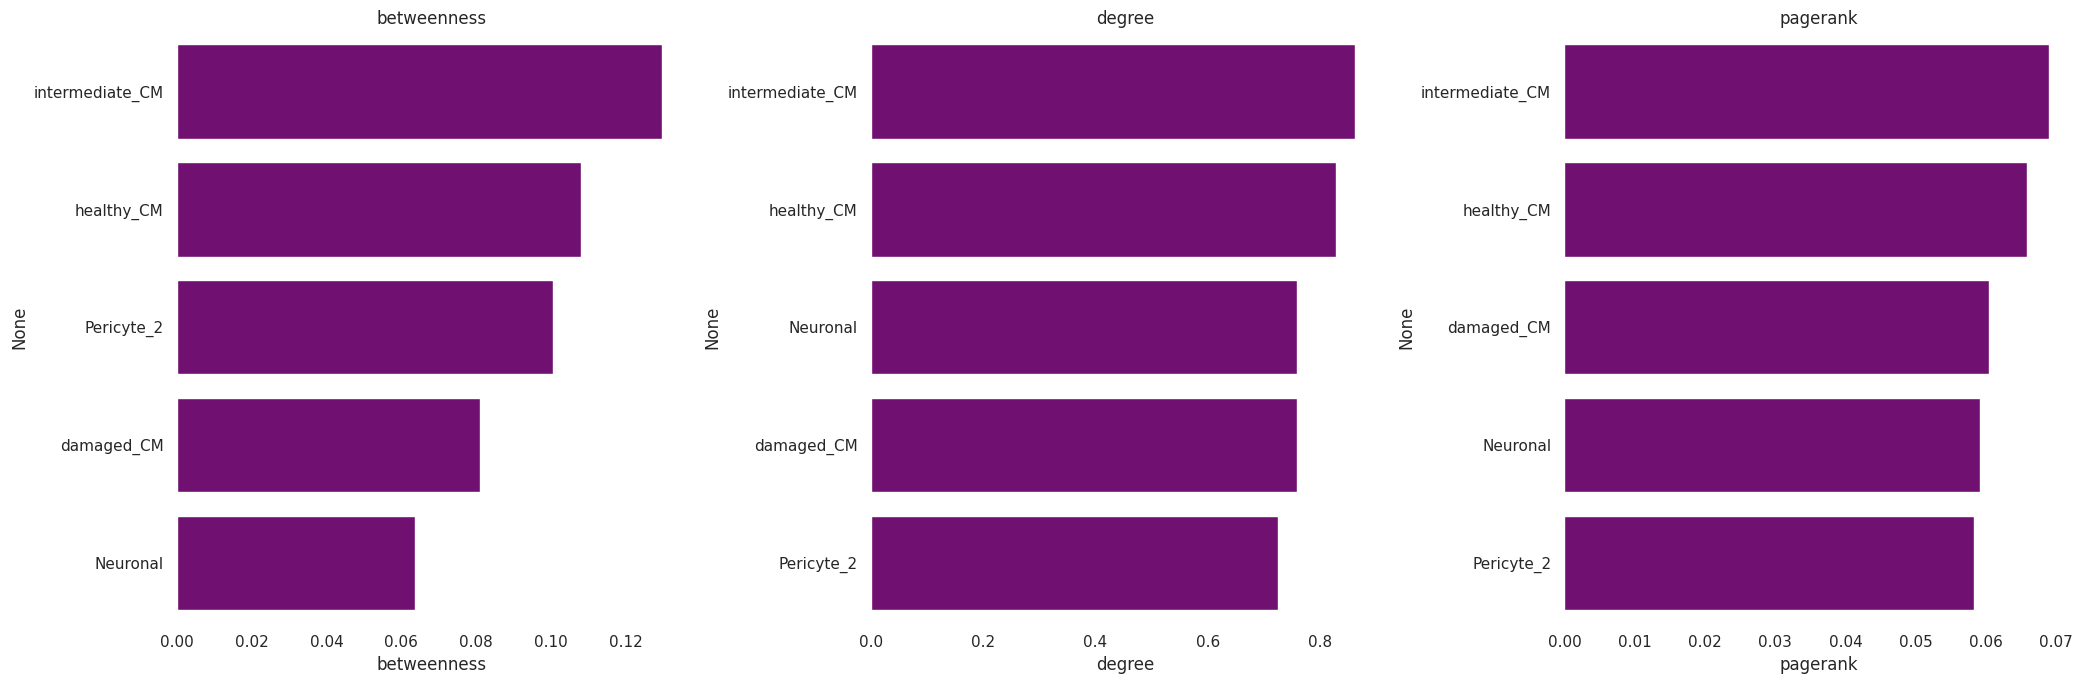

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
for i in range(len(t1.columns)):
    _ = sns.barplot(ax=axes[i], y=t1.sort_values(t1.columns[i], ascending=False).index[0:5], x=t1.columns[i], 
        data=t1.sort_values(t1.columns[i], ascending=False)[0:5], color='purple')
    axes[i].set_title(t1.columns[i])
fig.tight_layout()

So we can look separately at positive and negative degree:

In [34]:
## Positive edges degree
G_pos=gCol.copy()
to_remove=[(a,b) for a, b, attrs in G_pos.edges(data=True) if attrs["weight"] <= 0]
G_pos.remove_edges_from(to_remove)

t1=pd.DataFrame({'degree':[nx.degree_centrality(G_pos)[x] for x in list(G_pos.nodes)]})
t1.index=list(G_pos.nodes)

In [35]:
## Negative edges degree
G_neg=gCol.copy()
to_remove=[(a,b) for a, b, attrs in G_neg.edges(data=True) if attrs["weight"] >= 0]
G_neg.remove_edges_from(to_remove)

t2=pd.DataFrame({'degree':[nx.degree_centrality(G_neg)[x] for x in list(G_neg.nodes)]})
t2.index=list(G_neg.nodes)

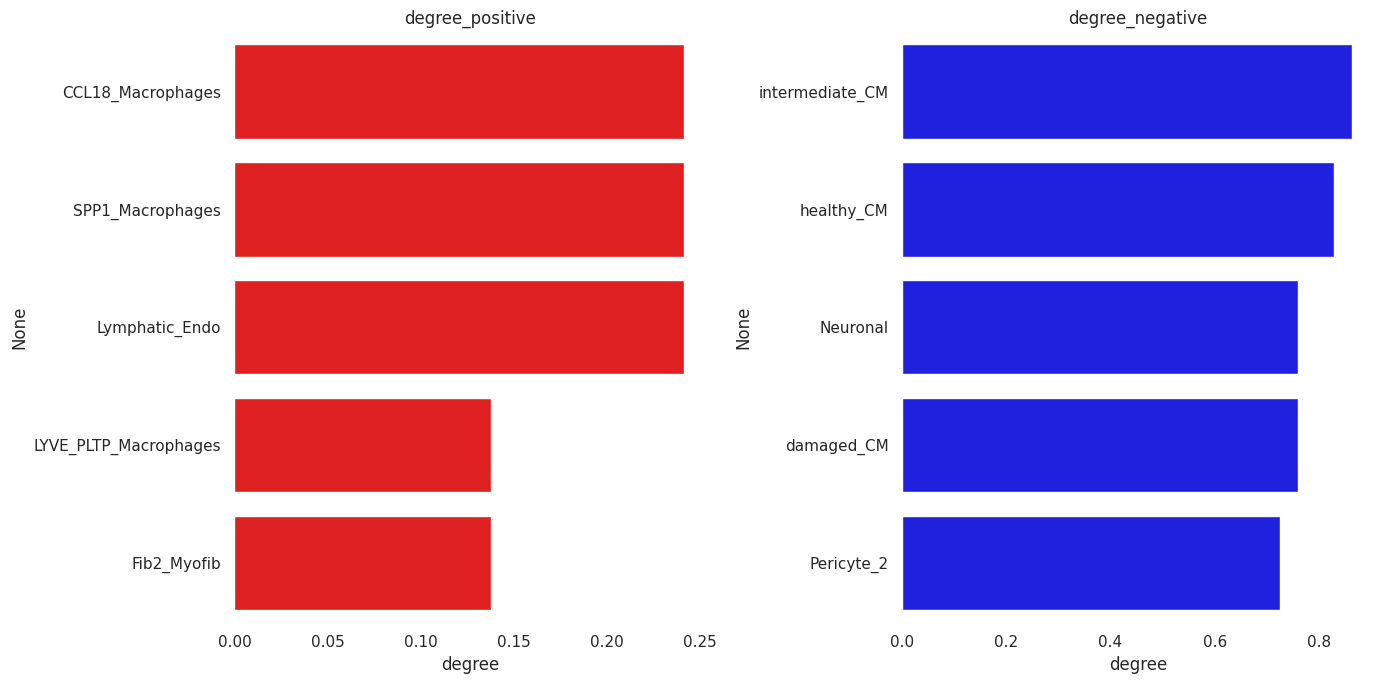

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

_=sns.barplot(ax=axes[0], y=t1.sort_values('degree', ascending=False).index[0:5], x='degree', 
              data=t1.sort_values('degree', ascending=False)[0:5], color='red')
axes[0].set_title('degree_positive')

_=sns.barplot(ax=axes[1], y=t2.sort_values('degree', ascending=False).index[0:5], x='degree', 
              data=t2.sort_values('degree', ascending=False)[0:5], color='blue')
axes[1].set_title('degree_negative')

fig.tight_layout()

Now we will visualize the **niches** in the **slices** coloring the Visium spots according to the niche of the cell type with the highest proportion. 

These are a couple **myogenic** slices, which will be at the **top** panels of the next figure:

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(21, 7))
plt.close(fig)
for idu,smpl in enumerate(list(sampleTypesDF['sample'][sampleTypesDF['sampleType']=='myogenic'][0:3])):  
    _ = nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), 
                                       CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]],    #dataframe of cell type probabilities per spot
                                       cell_types=mudata['sc'].obs.cell_subtype2,                    #categorical series of cell types
                                       nicheDF=niches_df, 
                                       spot_size=0.015, 
                                       niche_colors=niche_cols,                                      #series of colors with niche names as indexes
                                       legend_fontsize=7, save_name='_'+smpl+'.pdf',ax=axes[0][idu])

saving figure to file figures/show_control_P17.pdf


<Figure size 640x480 with 0 Axes>

saving figure to file figures/show_control_P7.pdf


<Figure size 640x480 with 0 Axes>

saving figure to file figures/show_control_P1.pdf


<Figure size 640x480 with 0 Axes>

And a couple **ischemic** slices, which will be at the **bottom** panels of the next figure:

In [38]:
for idu,smpl in enumerate(list(sampleTypesDF['sample'][sampleTypesDF['sampleType']=='ischemic'][0:3])):  
    _ = nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), 
                                       CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]], 
                                       cell_types=mudata['sc'].obs.cell_subtype2, 
                                       nicheDF=niches_df, 
                                       spot_size=0.015, 
                                       niche_colors=niche_cols, 
                                       legend_fontsize=7, 
                                       save_name='_'+smpl+'.pdf',ax=axes[1][idu])


saving figure to file figures/show_IZ_P15.pdf


<Figure size 640x480 with 0 Axes>

saving figure to file figures/show_GT_IZ_P13.pdf


<Figure size 640x480 with 0 Axes>

saving figure to file figures/show_GT_IZ_P15.pdf


<Figure size 640x480 with 0 Axes>

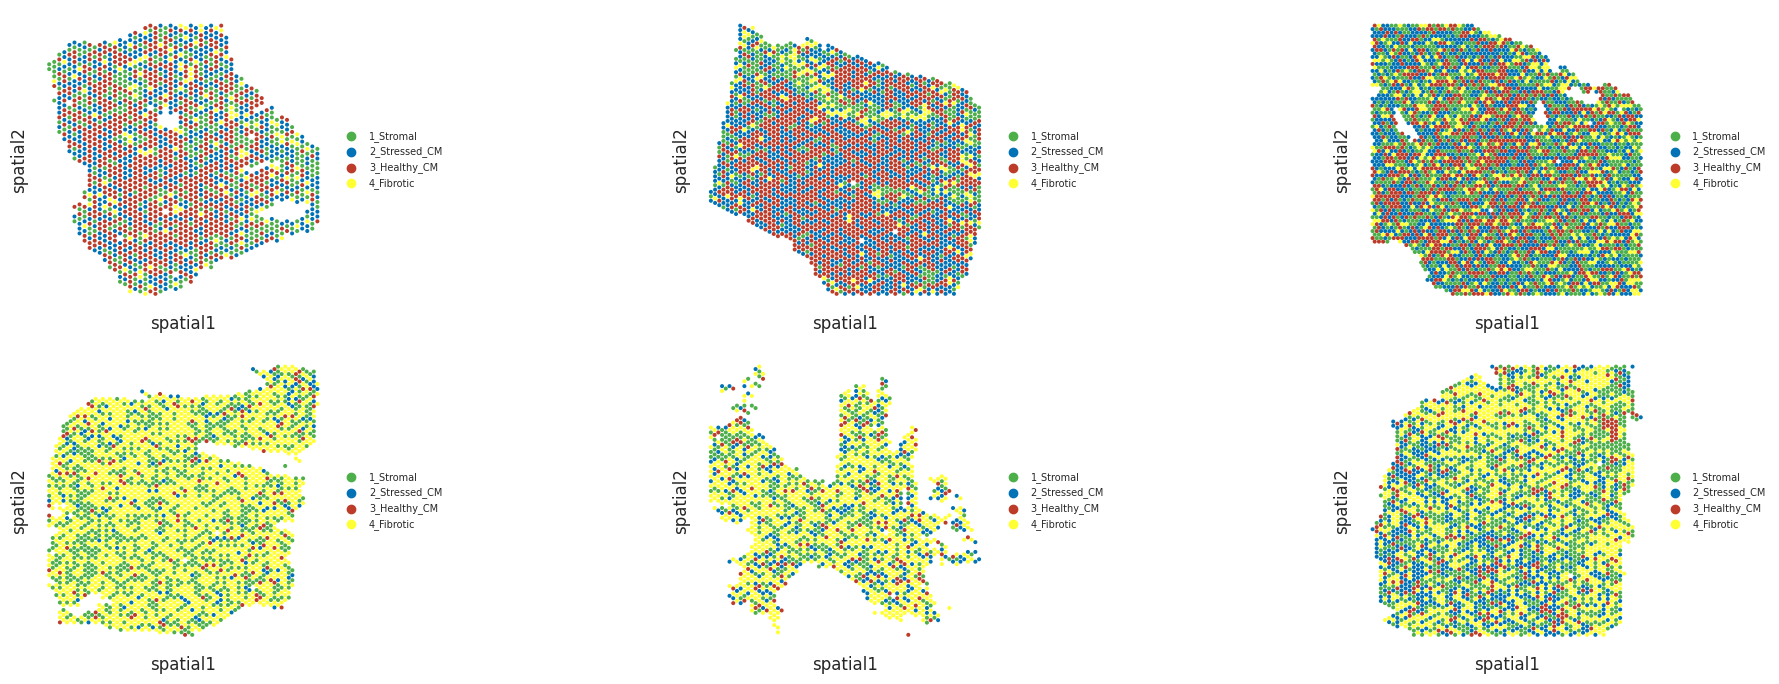

In [39]:
fig.tight_layout()
fig

For further analysis, we will need the correspondence data between cell pairs and niche pairs

In [40]:
pairCatDFdir=nichesphere.tl.get_pairCatDFdir(niches_df)
pairCatDFdir.head()

cell_pairs               niche_pairs
0            Fib1_SCARA5->Fib1_SCARA5      1_Stromal->1_Stromal
1             Fib1_SCARA5->damaged_CM  1_Stromal->2_Stressed_CM
2         Fib1_SCARA5->Capillary_Endo  1_Stromal->2_Stressed_CM
3  Fib1_SCARA5->LYVE_FOLR_Macrophages  1_Stromal->2_Stressed_CM
4                Fib1_SCARA5->Fib3_C7      1_Stromal->1_Stromal

We will also need a filtering object **(colocFilt)** indicating which cell pairs are differentially co-localized to filter the communication data

In [41]:
## Get data of cells present in the adjacency matrix
pairCatDF_filter=[(pairCatDFdir.cell_pairs.str.split('->')[i][0] in HMsimm.index)&
                  (pairCatDFdir.cell_pairs.str.split('->')[i][1] in HMsimm.index) for i in pairCatDFdir.index]
pairCatDFdir_filt=pairCatDFdir[pairCatDF_filter]
oneCTints_filt=oneCTints[[i.split('-')[0] in HMsimm.index for i in oneCTints]]

In [42]:
## Get data to flag differentially co-localized cell pairs in the adjacency matrix
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir_filt, 
                                        adj=HMsimm, 
                                        oneCTints=oneCTints_filt.str.replace('-', '->'))
colocFilt.head()

filter
cell_pairs                                
Fib1_SCARA5->Fib1_SCARA5               1.0
Fib1_SCARA5->damaged_CM                1.0
Fib1_SCARA5->Capillary_Endo            1.0
Fib1_SCARA5->LYVE_FOLR_Macrophages     0.0
Fib1_SCARA5->Fib3_C7                   1.0

## 5. LR based cell communication

We are interested in cell communication related to fibrosis, so we will use a database which classifies ligands according to extracellular matrix (ECM) or immune cell recruitment related processes to look for disease related processes : 

In [43]:
allDBs=pd.read_csv('../../../../data_vt3/second/nichesphere/nichesphereDB_pmid.csv', index_col=0)
allDBs.head()

Ligand   category         db      PMID
2  col1a1  Collagens  matrisome  36399478
3  col1a2  Collagens  matrisome  36399478
4  col1a1  Collagens  matrisome  36399478
5  col6a3  Collagens  matrisome  36399478
6  col1a2  Collagens  matrisome  36399478

<Axes: xlabel='count', ylabel='category'>

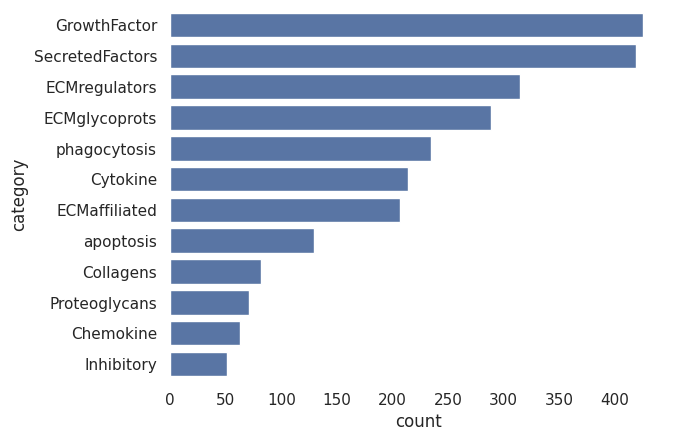

In [44]:
sns.barplot(x=allDBs.category.value_counts(), y=allDBs.category.value_counts().index,
            data=pd.DataFrame(allDBs.category.value_counts()))

Nichesphere is suited to work with CrossTalkeR output tables which contain columns called **cellpair**, indicating the cell types involved in an interaction separated by '@'; and **allpair**, indicating cell types, ligand and receptor involved. Additionally, input tables for Nichesphere should contain columns indicating the **ligand** (gene_A), **receptor** (gene_B) and **communication score** (MeanLR). The names for these last 3 columns can be indicated in Nichesphere functions.

CrossTalkeR tables contain strings indicating wether a gene is a ligand (|L), receptor (|R) or transcription factor (|TF). These strings will be removed as they might cause conflicts with code. Then we'll separate communication scores by process to know which cell type pairs and niche pairs are interacting through which processes in each condition. 

Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions. After this, we get the following tables

In [45]:
myoCTpairScores_byCat2_dir_colocClusts=pd.read_csv('../../../../data_vt3/second/nichesphere/processed_myo_ctkr_louvainColoc.csv', index_col=0)
iscCTpairScores_byCat2_dir_colocClusts=pd.read_csv('../../../../data_vt3/second/nichesphere/processed_isc_ctkr_louvainColoc.csv', index_col=0)

myoCTpairScores_byCat2_dir_colocClusts.head()

cell_pairs  \
allpair                                                          
Adipo/COL14A1@Arterial_Endo/CD44          Adipo->Arterial_Endo   
Adipo/COL14A1@CCL18_Macrophages/CD44  Adipo->CCL18_Macrophages   
Adipo/COL14A1@CD_4/CD44                            Adipo->CD_4   
Adipo/COL14A1@CD_8/CD44                            Adipo->CD_8   
Adipo/COL14A1@Fib1_SCARA5/CD44              Adipo->Fib1_SCARA5   

                                                   niche_pairs  LRscores  \
allpair                                                                    
Adipo/COL14A1@Arterial_Endo/CD44       1_Stromal->3_Healthy_CM  0.717175   
Adipo/COL14A1@CCL18_Macrophages/CD44     1_Stromal->4_Fibrotic  0.967985   
Adipo/COL14A1@CD_4/CD44               1_Stromal->2_Stressed_CM  0.967985   
Adipo/COL14A1@CD_8/CD44               1_Stromal->2_Stressed_CM  0.967985   
Adipo/COL14A1@Fib1_SCARA5/CD44            1_Stromal->1_Stromal  0.967985   

                                          LRcat condition  
allpair                                                    
Adipo/COL14A1@Arterial_Endo/CD44      Collagens  myogenic  
Adipo/COL14A1@CCL18_Macrophages/CD44  Collagens  myogenic  
Adipo/COL14A1@CD_4/CD44               Collagens  myogenic  
Adipo/COL14A1@CD_8/CD44               Collagens  myogenic  
Adipo/COL14A1@Fib1_SCARA5/CD44        Collagens  myogenic

Names of cell types need to match between communication and co-localization data

Next, we will **filter by differential co-localization** using the **colocFilt** filtering object we created before: 

In [46]:
myoCTpairScores_byCat2_dir_colocClusts=myoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in myoCTpairScores_byCat2_dir_colocClusts.cell_pairs]]
iscCTpairScores_byCat2_dir_colocClusts=iscCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in iscCTpairScores_byCat2_dir_colocClusts.cell_pairs]]

Then we can test for **differential cell communication** between niche pairs or cell pairs across processes with the function **diffCcommStats**. We will first test per niche pair setting the parameter **cellCatCol** to 'niche_pairs', which is the column in the tables of communication scores by process containing niche pairs:

In [47]:
myoIsc_diffCcommTable_colocGroups_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, 
                                                                      c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, 
                                                                      cellCatCol='niche_pairs')
myoIsc_diffCcommTable_colocGroups_dir.head()

wilcoxStat     wilcoxPval                      cellCat      LRcat
0   11.596600   4.287770e-31  3_Healthy_CM->2_Stressed_CM  Collagens
1    7.014138   2.313703e-12      3_Healthy_CM->1_Stromal  Collagens
2   14.893355   3.640346e-50   3_Healthy_CM->3_Healthy_CM  Collagens
3   23.624021  2.183538e-123       4_Fibrotic->4_Fibrotic  Collagens
4    4.024180   5.717429e-05        4_Fibrotic->1_Stromal  Collagens

And reshape the data to plot the differential communication scores in a heatmap. Just as for the co-localization analysis, **Wilcoxon rank sums tests** are employed here. The **diffCcommStats** function returns then the table of scores per niche pair per process and the plot itself.

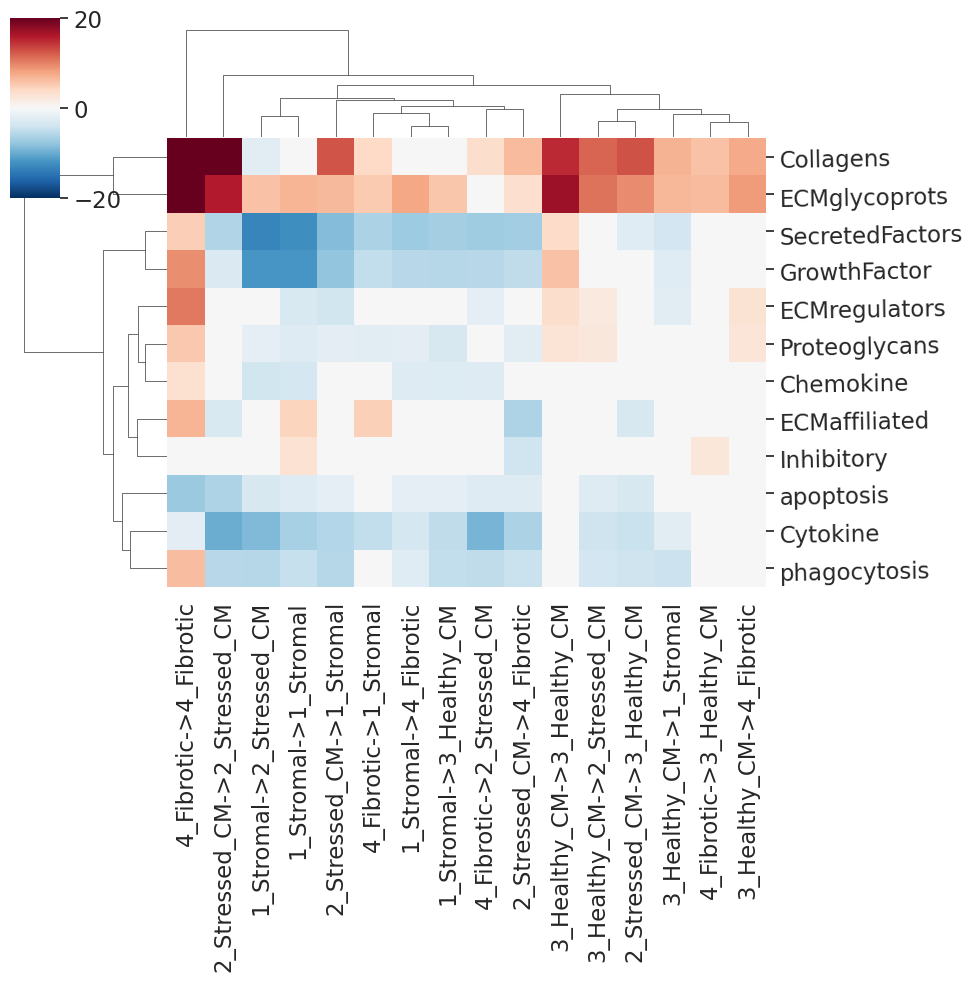

In [48]:
hm_df, cm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable_colocGroups_dir, 
                                                min_pval=0.05, 
                                                vmin=-20, vmax=20)

**Localized differential communication networks**

To build process specific differential cell communication networks, we will look at differential cell communication per cell type pair per process, so we will do the differential communication test again with the **diffCcommStats** function, this time setting **cellCatCol** to 'cell_pairs', which is the column in the tables of communication scores by process containing cell pairs.

In [49]:
myoIsc_diffCcommTable2_CTpair_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, 
                                                                  c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, 
                                                                  cellCatCol='cell_pairs')

We must reshape the data as we will need this for the **communication networks**, and get the heatmap of differential communication scores per cell pair.

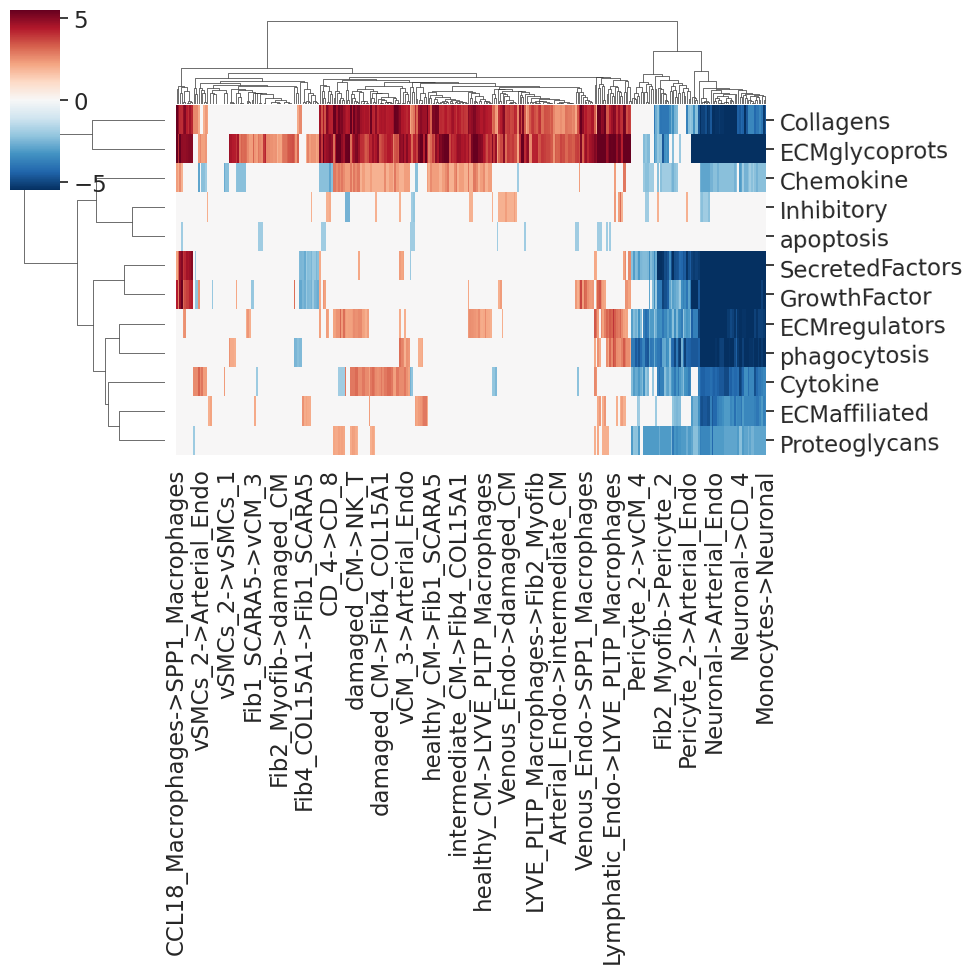

In [50]:
x_myoIsc_dir, plothm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable2_CTpair_dir, 
                                                           min_pval=0.05, 
                                                           vmin=-5.5, vmax=5.5)

Then we will get the **differential communication scores** for a specific **process**

In [51]:
x_chem=nichesphere.comm.getDiffComm(diffCommTbl=x_myoIsc_dir, 
                                    pairCatDF=pairCatDFdir, 
                                    ncells=33, 
                                    cat='ECMglycoprots')
x_chem.head()

Fib1_SCARA5  damaged_CM  Capillary_Endo  \
Fib1_SCARA5               0.000000    2.845702        2.685997   
damaged_CM                3.604778    0.000000        4.424010   
Capillary_Endo            3.142450    3.364136        0.000000   
LYVE_FOLR_Macrophages     0.000000    3.584589        0.000000   
Fib3_C7                   2.419413    3.026513        2.898491   

                       LYVE_FOLR_Macrophages   Fib3_C7  healthy_CM  \
Fib1_SCARA5                         0.000000  2.291307    2.280662   
damaged_CM                          4.141256  4.066038    3.376389   
Capillary_Endo                      0.000000  3.357803    3.326268   
LYVE_FOLR_Macrophages               0.000000  0.000000    3.055622   
Fib3_C7                             0.000000  0.000000    2.454029   

                       Fib2_Myofib  Endocardial_Endo  Arterial_Endo  Neuronal  \
Fib1_SCARA5               2.723508          0.000000       0.000000 -7.984900   
damaged_CM                4.209408          4.020863       4.408857 -6.539320   
Capillary_Endo            0.000000          2.268819       3.101101 -7.089490   
LYVE_FOLR_Macrophages     0.000000          0.000000       0.000000 -6.539320   
Fib3_C7                   0.000000          0.000000       2.567224 -7.890426   

                       ...  CCL18_Macrophages  perivascular_fibroblasts  \
Fib1_SCARA5            ...            0.00000                       0.0   
damaged_CM             ...            0.00000                       0.0   
Capillary_Endo         ...            0.00000                       0.0   
LYVE_FOLR_Macrophages  ...            0.00000                       0.0   
Fib3_C7                ...            3.59563                       0.0   

                           CD_4   vSMCs_2  Lymphatic_Endo   NK      CD_8  \
Fib1_SCARA5            0.000000  0.000000             0.0  0.0  0.000000   
damaged_CM             4.756736  3.377464             0.0  0.0  4.701915   
Capillary_Endo         3.930870  0.000000             0.0  0.0  3.887976   
LYVE_FOLR_Macrophages  0.000000  0.000000             0.0  0.0  0.000000   
Fib3_C7                0.000000  0.000000             0.0  0.0  0.000000   

                       Purkinje_fibers  Adipo      NK_T  
Fib1_SCARA5                        0.0    0.0  0.000000  
damaged_CM                         0.0    0.0  5.139999  
Capillary_Endo                     0.0    0.0  0.000000  
LYVE_FOLR_Macrophages              0.0    0.0  0.000000  
Fib3_C7                            0.0    0.0  0.000000  

[5 rows x 33 columns]

And now we can **plot differential cell communication** scores per process on the edges of the co-localization network using the **catNW** function from Nichesphere, whose parameters are quite similar to the ones of the **colocMW** function

<Figure size 640x480 with 0 Axes>

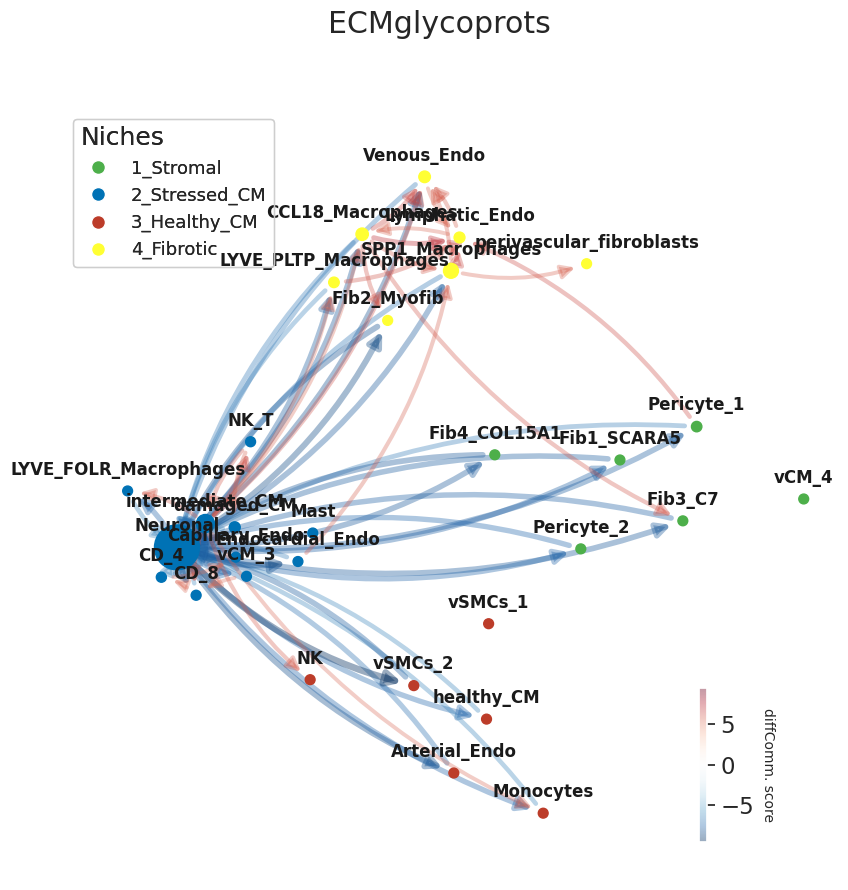

In [52]:
plt.rcParams['axes.facecolor'] = "None"
plt.figure(frameon=False)

G=nichesphere.comm.catNW(x_chem=x_chem,
                         colocNW=gCol, 
                         cell_group=niches_dict,  
                         plot_title='ECMglycoprots', 
                         clist=clist, 
                         nodeSize='betweeness', 
                         layout=None, 
                         thr=5.5,                       #only edges with weights higher than this value are shown
                         fsize=(10,10), 
                         alpha=0.4, 
                         edge_scale=0.5, 
                         pos=pos, 
                         lab_spacing=0.05)
#Legend
legend_elements1=[plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[i], lw=4, 
                             label=list(niches_dict.keys())[i], ms=10) for i in range(len(list(niches_dict.keys())))]
plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', 
                                alignment='left'))
#plt.savefig('./ECMglycoprots_diffCommNW.pdf')

As we did before, we will calculate some network statistics with the networkx package functions on the signed, directed differential communication network

In [53]:
t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 
                 #'degree':[nx.degree_centrality(G)[x] for x in list(G.nodes)], 
                 'in_degree':[nx.in_degree_centrality(G)[x] for x in list(G.nodes)],
                 'out_degree':[nx.out_degree_centrality(G)[x] for x in list(G.nodes)],
                 'pagerank':[nx.pagerank(G, weight=None)[x] for x in list(G.nodes)]})
t1.index=list(G.nodes)

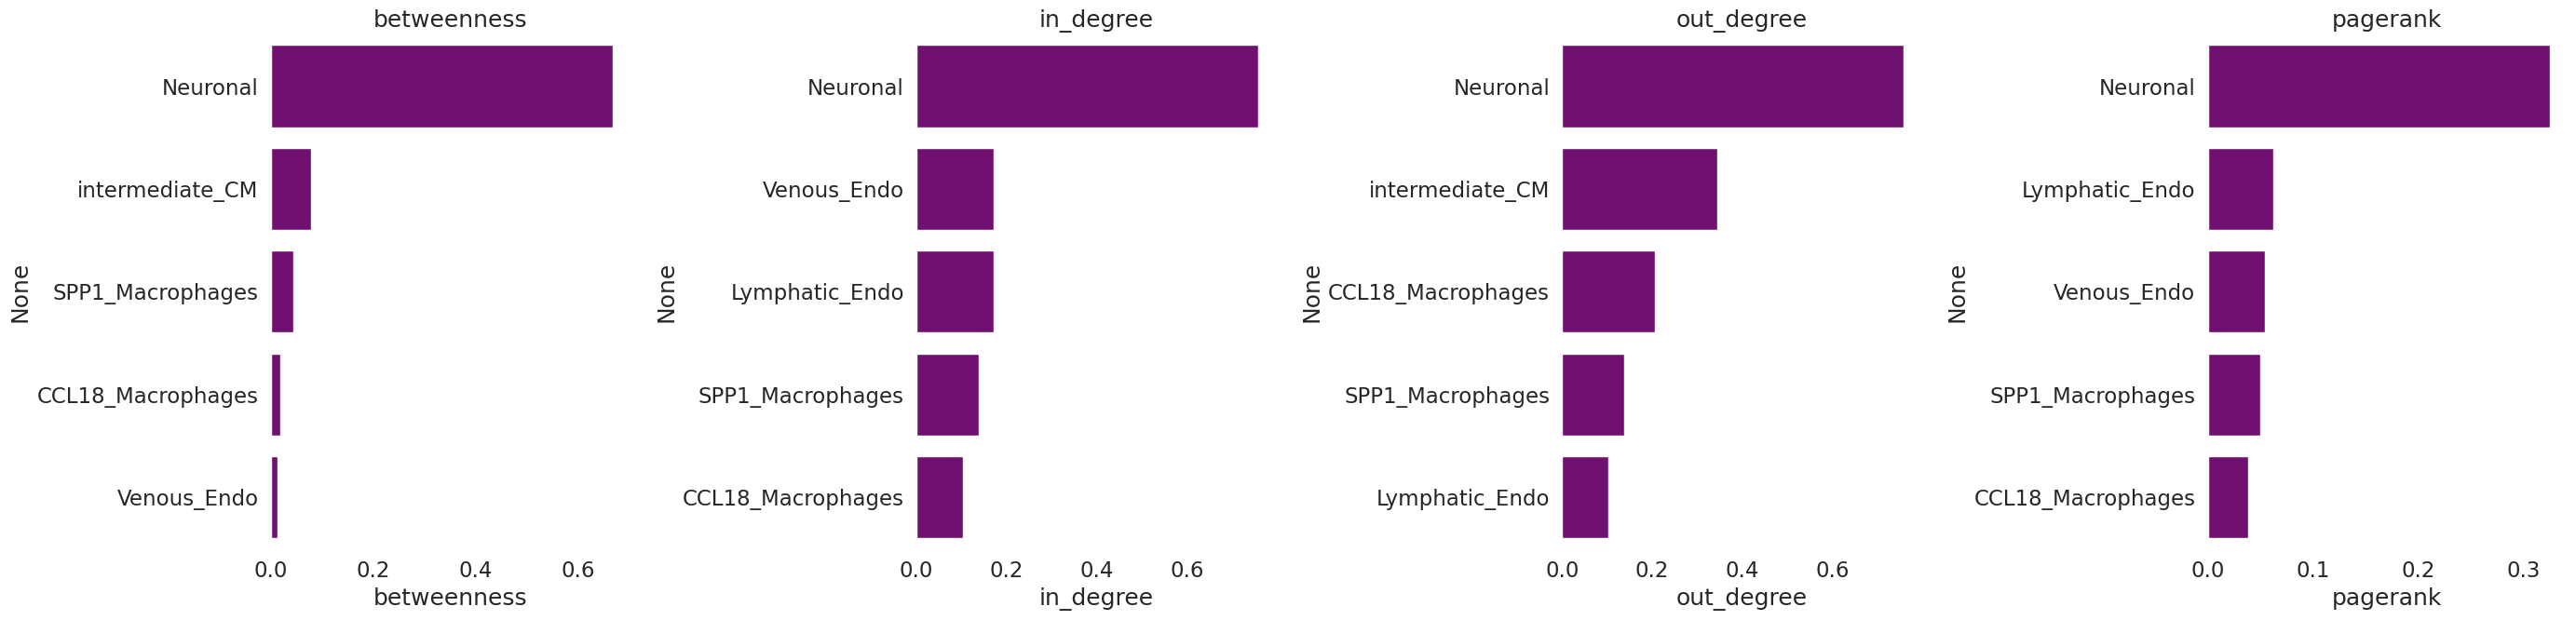

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(28, 7))
for i in range(len(t1.columns)):
    _ = sns.barplot(ax=axes[i], y=t1.sort_values(t1.columns[i], ascending=False).index[0:5], x=t1.columns[i], 
        data=t1.sort_values(t1.columns[i], ascending=False)[0:5], color='purple')
    axes[i].set_title(t1.columns[i])
fig.tight_layout()

And look separately at positive and negative in and out - degree of the nodes:

In [55]:
G_pos=G.copy()
to_remove=[(a,b) for a, b, attrs in G_pos.edges(data=True) if attrs["weight"] <= 0]
G_pos.remove_edges_from(to_remove)
t1=pd.DataFrame({'in_degree':[nx.in_degree_centrality(G_pos)[x] for x in list(G_pos.nodes)],
                 'out_degree':[nx.out_degree_centrality(G_pos)[x] for x in list(G_pos.nodes)]})
t1.index=list(G_pos.nodes)

In [56]:
G_neg=G.copy()
to_remove=[(a,b) for a, b, attrs in G_neg.edges(data=True) if attrs["weight"] >= 0]
G_neg.remove_edges_from(to_remove)
t2=pd.DataFrame({'in_degree':[nx.in_degree_centrality(G_neg)[x] for x in list(G_neg.nodes)],
                 'out_degree':[nx.out_degree_centrality(G_neg)[x] for x in list(G_neg.nodes)]})
t2.index=list(G_neg.nodes)

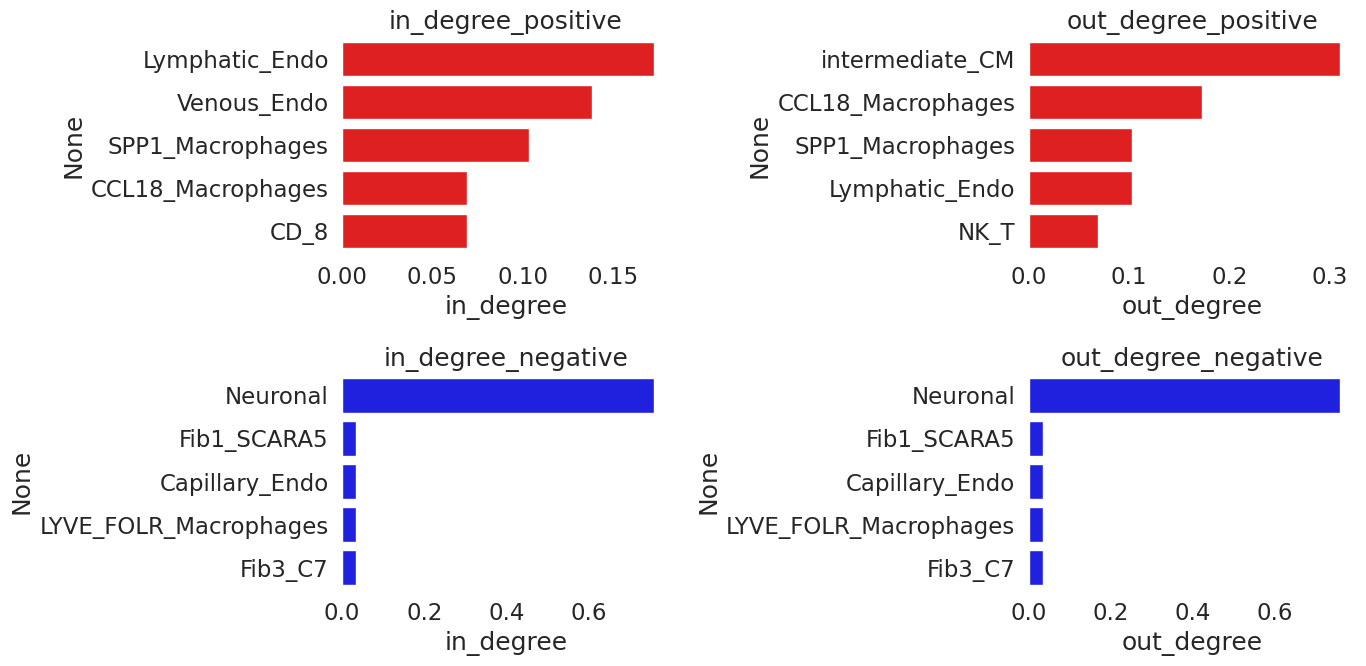

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
sns.barplot(ax=axes[0][0], y=t1.sort_values('in_degree', ascending=False).index[0:5], x='in_degree', 
            data=t1.sort_values('in_degree', ascending=False)[0:5], color='red')
axes[0][0].set_title('in_degree_positive')
sns.barplot(ax=axes[0][1], y=t1.sort_values('out_degree', ascending=False).index[0:5], x='out_degree', 
            data=t1.sort_values('out_degree', ascending=False)[0:5], color='red')
axes[0][1].set_title('out_degree_positive')
sns.barplot(ax=axes[1][0], y=t2.sort_values('in_degree', ascending=False).index[0:5], x='in_degree', 
            data=t2.sort_values('in_degree', ascending=False)[0:5], color='blue')
axes[1][0].set_title('in_degree_negative')
sns.barplot(ax=axes[1][1], y=t2.sort_values('out_degree', ascending=False).index[0:5], x='out_degree', 
            data=t2.sort_values('out_degree', ascending=False)[0:5], color='blue')
axes[1][1].set_title('out_degree_negative')
fig.tight_layout()